In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
RANDOM_STATE = 42

In [3]:
data = pd.read_csv('../data/raw/heart_disease.csv')

In [4]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [5]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,2.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,0.602694,0.676768,0.835017,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,0.956690,0.499340
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,2.000000,1.000000


There are 13 attributes

1. age: age in years
2. sex: sex (1 = male; 0 = female)
3. cp: chest pain type
    - Value 0: typical angina
    - Value 1: atypical angina
    - Value 2: non-anginal pain
    - Value 3: asymptomatic
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak = ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
    - Value 0: upsloping
    - Value 1: flat
    - Value 2: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: 
    - 0 = normal;
    - 1 = fixed defect;
    - 2 = reversable defect


**TARGET**


- condition:
    - 0 = no disease,
    - 1 = disease

### Непрерывные и категориальные признаки

In [6]:
numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', ]
categorical = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
target = 'condition'

### Распределения признаков

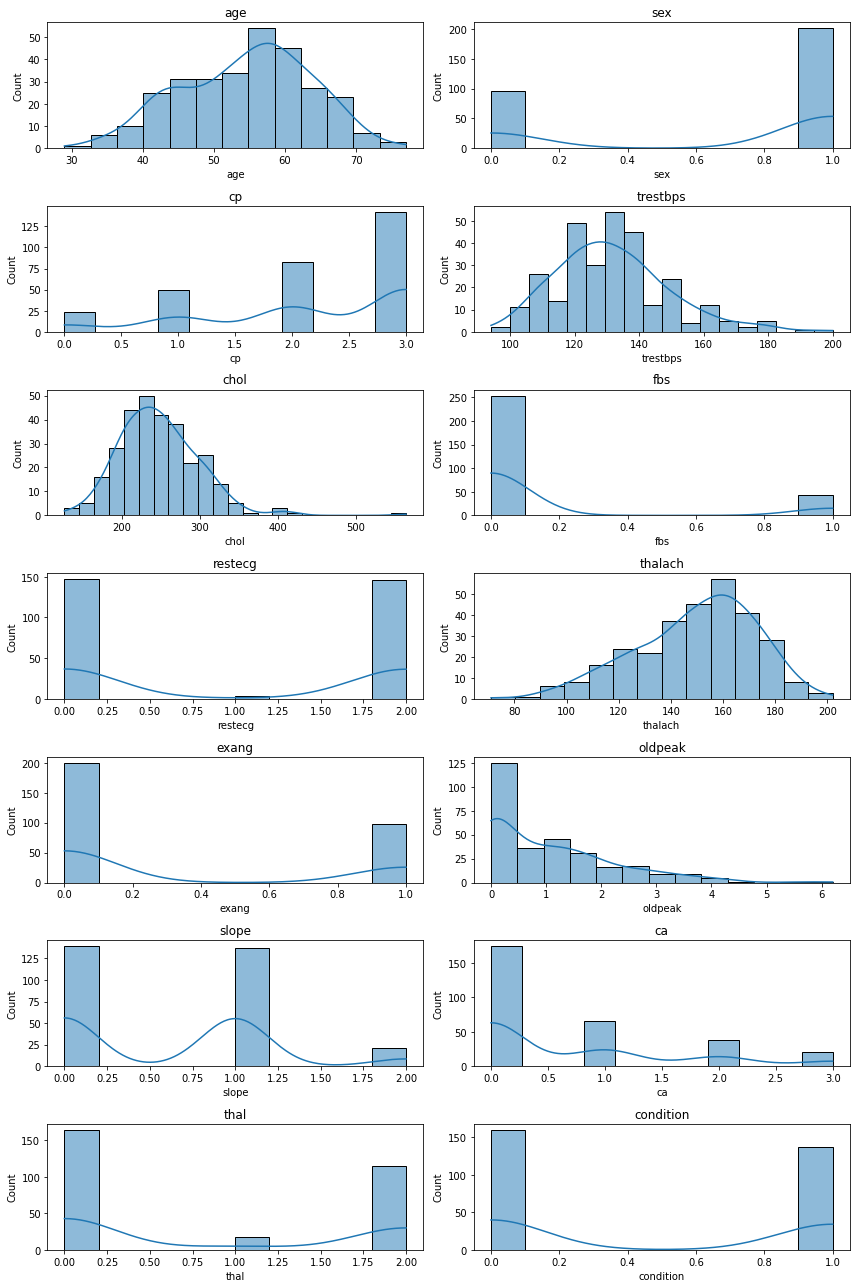

In [7]:
fig, ax = plt.subplots(7, 2, figsize=(12, 18))
for i in range(len(data.columns) // 2):
    for j in range(2):
        sns.histplot(data.iloc[:, 2 * i + j], kde=True, ax=ax[i][j])
        ax[i][j].set_title(data.columns[2 * i + j])
plt.tight_layout()

### Проверка на наличие nan

In [8]:
data.isnull().sum().sum()

0

Нет пропущенных значений

### Data transformer

In [9]:
ohe = OneHotEncoder()
scaler = StandardScaler()

transformer = ColumnTransformer([('cat', ohe, categorical), ('num', scaler, numerical)])

In [10]:
def train_model(X, y, transformer, model):
    pipeline = Pipeline([('transform', transformer), ('model', model)])
    pipeline.fit(X, y)
    return pipeline

In [11]:
def validate_model(X, y_true, pipeline):
    pred = pipeline.predict(X)
    print(classification_report(pred, y_true))
    print('ROC_AUC:', roc_auc_score(pred, y_true))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(target, axis=1),
                                                    data[target],
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE,
                                                    stratify=data[target])

In [13]:
model = RandomForestClassifier()
pipeline = train_model(X_train, y_train, transformer, model)

In [14]:
validate_model(X_train, y_train, pipeline)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00       109

    accuracy                           1.00       237
   macro avg       1.00      1.00      1.00       237
weighted avg       1.00      1.00      1.00       237

ROC_AUC: 1.0


In [15]:
validate_model(X_test, y_test, pipeline)

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        40
           1       0.71      1.00      0.83        20

    accuracy                           0.87        60
   macro avg       0.86      0.90      0.86        60
weighted avg       0.90      0.87      0.87        60

ROC_AUC: 0.9


### Кастомный transformer

In [22]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    """Возвращает квадраты непрерывных признаков"""
    def __init__(self, numerical_feature_name):
        self.numerical_feature_name = numerical_feature_name
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.numerical_feature_name] = X_[self.numerical_feature_name] ** 2
        return X_

In [23]:
model = RandomForestClassifier()
transformer = CustomTransformer(numerical)
pipeline = train_model(X_train, y_train, transformer, model)

In [24]:
validate_model(X_train, y_train, pipeline)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00       109

    accuracy                           1.00       237
   macro avg       1.00      1.00      1.00       237
weighted avg       1.00      1.00      1.00       237

ROC_AUC: 1.0


In [25]:
validate_model(X_test, y_test, pipeline)

              precision    recall  f1-score   support

           0       0.97      0.79      0.87        39
           1       0.71      0.95      0.82        21

    accuracy                           0.85        60
   macro avg       0.84      0.87      0.84        60
weighted avg       0.88      0.85      0.85        60

ROC_AUC: 0.8736263736263736
